## 02. Using the GALACTICNUCLEUS catalog

This script aims to simulate a spectral image that would be observed using slitless spectroscopy, using the data on the star position and flux as was obtained from the GALACTICNUCLEUS survey. The original publication can be found [here](https://www.aanda.org/articles/aa/full_html/2019/11/aa36263-19/aa36263-19.html#S2) and the data can also be downloaded from [here](http://cdsarc.unistra.fr/viz-bin/cat/J/A+A/631/A20). 

Script written by: **Soumya Shreeram** <br/> 
Project supervised by: **Francisco Nogueras-Lara and Nadine Neumayer (MPIA)** <br/>
Date: **05th October 2020** <br/>

In [2]:
import astropy.io.fits as fits
from scipy.sparse import csr_matrix
import scipy.stats as stats
import numpy as np
import os
import importlib

# generate random integer values
from random import seed
from random import randint

# plotting imports
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib import cm

# to show progress during computations
from time import sleep
import sys

import matplotlib
%matplotlib inline
font = {'family' : 'arial',
        'weight' : 'normal',
        'size'   : 20}
matplotlib.rc('font', **font)

Personal imports

In [3]:
import Simulating_Spectra as ss

#### 1. Defining input parameters

In [4]:
# setting up the working directory path
current_dir = os.getcwd()
data_dir = os.path.join(current_dir, "Data")

# putting together the file name
string_name = 'J_A+A_631_A20_central.dat.fits'
filename = os.path.join(data_dir, string_name)

 

In [20]:
def readCatalogFile(filename):
    """
    Function to read the magnitude and positions of the stars from the catalog file
    """
    hdu_list = fits.open(filename)
    # Ks band magnitude
    mag_Ks = hdu_list[1].data['Ksmag']

    # position of stars in the sky
    ra_Ks = hdu_list[1].data['RAKsdeg']
    de_Ks = hdu_list[1].data['DEKsdeg']

    # errors on magnitude and positions
    e_mag_Ks = hdu_list[1].data['e_Ksmag']
    e_ra_Ks = hdu_list[1].data['RAKsdeg']
    e_de_Ks = hdu_list[1].data['DEKsdeg']
    
    # close file
    hdu_list.close()
    
    errors = [e_mag_Ks, e_ra_Ks, e_de_Ks]
    return mag_Ks, ra_Ks, de_Ks, errors


In [21]:
mag_Ks, ra_Ks, de_Ks, errors = readCatalogFile(filename)

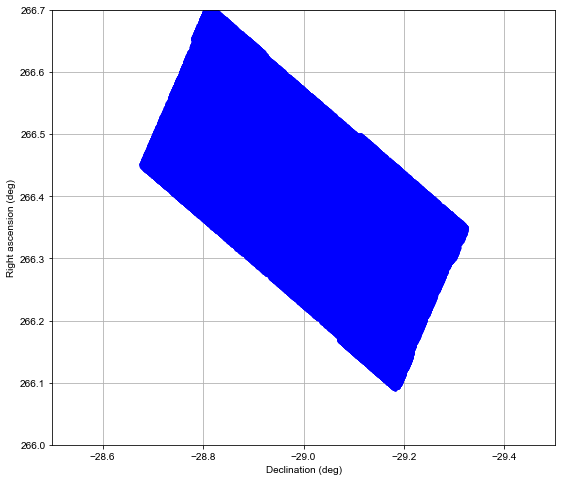

In [51]:
fig, ax = plt.subplots(1,1,figsize=(9,8))

# plotting the stars
ax.plot(de_Ks[0:-1], ra_Ks[0:-1], "b.")
ss.setLabel(ax, 'Declination (deg)', 'Right ascension (deg)', '', [-28.5, -29.5], [266, 266.7], legend=False)
